In [1]:
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Conv1D, Dropout, Flatten, Dense
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam
import matplotlib.pyplot as plt

2023-12-17 18:17:27.077399: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-17 18:17:27.080756: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-17 18:17:27.135436: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-17 18:17:27.137817: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-17 18:17:27.953410: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
server_url = '/home/c01009/Bicycle/Data/'
bycycle_year_path = server_url + 'weekday_re_df_1021.pkl'

In [3]:
df = pd.read_pickle(bycycle_year_path)

# df의 열 이름을 날짜 형식으로 변환
df.columns = pd.to_datetime(df.columns)

# 데이터 전처리: 날짜를 인덱스로 설정하고 행과 열을 바꿉니다.
df = df.transpose()

# df_transposed의 인덱스를 열로 변환하고 이름을 '일시'로 지정
df = df.reset_index().rename(columns={'index': '일시'})
df

,일시,3,4,5,6,7,8,9,10,11,...,2746,2747,2748,2749,2750,2751,2752,2753,2754,2755
0,2022-01-03,35,35,27,15,24,22,25,10,15,...,0,0,0,0,0,0,0,0,0,0
1,2022-01-04,43,24,23,21,27,25,25,14,14,...,0,0,0,0,0,0,0,0,0,0
2,2022-01-05,39,22,30,16,16,27,26,12,11,...,0,0,0,0,0,0,0,0,0,0
3,2022-01-06,40,36,24,18,20,26,23,14,16,...,0,0,0,0,0,0,0,0,0,0
4,2022-01-07,45,27,32,24,26,29,25,11,10,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,2022-12-26,38,19,25,13,25,25,33,15,7,...,24,50,42,25,66,16,14,8,27,3
256,2022-12-27,43,37,38,17,32,26,31,19,7,...,26,68,33,22,79,32,15,11,24,1
257,2022-12-28,45,31,29,21,18,25,27,16,9,...,27,67,22,25,62,20,15,6,20,7
258,2022-12-29,48,39,31,14,25,24,31,14,12,...,32,80,19,33,72,27,11,4,24,3


In [4]:
weather_df = pd.read_csv('/home/c01009/Bicycle/Data/weather_df.csv',encoding='cp949')
# 의미없는 열 삭제
weather_df = weather_df.drop('Unnamed: 0', axis=1)
# datetime으로 변경
weather_df['일시'] = pd.to_datetime(weather_df['일시'])
weather_df

,일시,강수량(mm),최고기온(℃),평균기온(℃),최저기온(℃),일교차,평균습도(%rh),일조율(%),평균풍속(m/s),최대풍속(m/s)
0,2022-01-01,0.0,2.3,-4.3,-10.2,12.5,46.3,93.8,1.5,2.8
1,2022-01-02,0.3,3.0,-1.3,-5.2,8.2,57.9,56.3,2.3,4.6
2,2022-01-03,0.0,2.5,-1.9,-8.0,10.5,58.3,80.4,1.8,4.1
3,2022-01-04,0.0,1.0,-2.5,-5.6,6.6,51.8,92.8,2.4,4.2
4,2022-01-05,0.0,1.9,-2.8,-7.8,9.7,47.6,19.6,1.7,2.9
...,...,...,...,...,...,...,...,...,...,...
360,2022-12-27,0.0,3.3,-2.6,-7.3,10.6,69.8,91.7,1.8,3.2
361,2022-12-28,0.1,0.1,-3.3,-6.0,6.1,58.1,90.6,2.5,4.9
362,2022-12-29,0.0,2.1,-2.9,-7.8,9.9,56.3,93.8,1.7,3.4
363,2022-12-30,0.0,2.3,-1.8,-4.4,6.7,65.6,82.3,1.9,4.6


In [5]:
# 데이터프레임에서 결측치가 있는 행만 출력
print(weather_df[weather_df.isna().any(axis=1)])
print(df[df.isna().any(axis=1)])

# 결측치 제거
df = df.dropna()
weather_df = weather_df.dropna()

            일시  강수량(mm)  최고기온(℃)  평균기온(℃)  최저기온(℃)  일교차  평균습도(%rh)  일조율(%)  \
219 2022-08-08    129.6     28.4     26.8      NaN  NaN       91.6     0.0   

     평균풍속(m/s)  최대풍속(m/s)  
219        3.3        8.6  
Empty DataFrame
Columns: [일시, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99, 100, 101, 102, 103, ...]
Index: []

[0 rows x 2710 columns]


In [6]:
# '일시' 열을 기준으로 공통된 행만 필터링
common_dates = weather_df['일시'].isin(df['일시'])
weather_df = weather_df[common_dates]

common_dates = df['일시'].isin(weather_df['일시'])
df = df[common_dates]

# 결과 확인
print(weather_df.shape)
print(df.shape)

(259, 10)
(259, 2710)


In [7]:
# 슬라이딩 윈도우와 예측 길이 설정
window_length = 3  # 3일 학습
forecast_length = 1 # 1일 예측

In [8]:
# 3~8월까지 train, 9월 test
x_train_df = weather_df[(weather_df['일시'] >= '2022-03-01') & (weather_df['일시'] < '2022-09-01')]
y_train_df = df[(df['일시'] >= '2022-03-01') & (df['일시'] < '2022-09-01')]

x_test_df = weather_df[(weather_df['일시'] >= '2022-09-01') & (weather_df['일시'] < '2022-10-01')]
y_test_df = df[(df['일시'] >= '2022-09-01') & (df['일시'] < '2022-10-01')]

In [9]:
print(y_train_df.shape)
print(x_train_df.shape)
print(y_test_df.shape)
x_test_df.shape

(131, 2710)
(131, 10)
(22, 2710)


(22, 10)

In [10]:
# 데이터셋 병합 함수
def combine_datasets(x_df, y_df):
    # '일시' 열을 기준으로 두 데이터셋을 합칩니다
    combined_df = pd.merge(x_df, y_df, on='일시')
    return combined_df

In [11]:
# 슬라이딩 윈도우 방식으로 데이터셋 생성 함수
def create_dataset(x, y, window_length, forecast_length):
    X, y_new = [], []
    for i in range(len(x) - window_length - forecast_length + 1):
        X.append(x.iloc[i:(i + window_length)].values.flatten())
        y_new.append(y.iloc[(i + window_length):(i + window_length + forecast_length)].values.flatten())
    return np.array(X), np.array(y_new)

In [12]:
# 훈련 및 테스트 데이터셋 생성
train_df = combine_datasets(x_train_df, y_train_df)
test_df = combine_datasets(x_test_df, y_test_df)

In [13]:
# 슬리이딩 윈도우를 적용한 train, test 셋 생성
X_train, y_train = create_dataset(train_df.iloc[:, :-2709], train_df.iloc[:, -2709:], window_length, forecast_length)
X_test, y_test = create_dataset(test_df.iloc[:, :-2709], test_df.iloc[:, -2709:], window_length, forecast_length)

In [14]:
### 모델에 넣을 때 time stamp 제거
# X_train 배열에서 Timestamp 객체 제거
new_X_train = np.array([np.array([x for x in row if not isinstance(x, pd.Timestamp)]) for row in X_train])
new_X_train

## 위에서 train, test셋이 sliding window로 적용된 것을 확인했다면, 이제는 XGBoost 모델에 넣기 위해서
# Timestamp 형식을 제거하여 numeric feature로 변환
 
# NumPy 배열을 DataFrame으로 변환
X_test_df = pd.DataFrame(X_test)

# Timestamp 타입의 열 제거
X_test_df = X_test_df.select_dtypes(exclude=['datetime64[ns]'])

# DataFrame을 다시 NumPy 배열로 변환
new_X_test = X_test_df.to_numpy()
new_X_test

array([[0.0, 30.4, 24.0, 18.3, 12.1, 70.8, 93.1, 1.7, 4.3, 0.0, 29.8,
        24.7, 20.3, 9.5, 61.8, 89.2, 3.1, 5.3, 120.0, 22.7, 19.2, 17.7,
        5.0, 95.9, 0.0, 3.2, 6.9],
       [0.0, 29.8, 24.7, 20.3, 9.5, 61.8, 89.2, 3.1, 5.3, 120.0, 22.7,
        19.2, 17.7, 5.0, 95.9, 0.0, 3.2, 6.9, 25.3, 26.3, 21.0, 17.0,
        9.3, 78.0, 65.6, 3.6, 7.1],
       [120.0, 22.7, 19.2, 17.7, 5.0, 95.9, 0.0, 3.2, 6.9, 25.3, 26.3,
        21.0, 17.0, 9.3, 78.0, 65.6, 3.6, 7.1, 0.0, 28.1, 22.8, 17.9,
        10.2, 65.3, 93.0, 1.9, 4.0],
       [25.3, 26.3, 21.0, 17.0, 9.3, 78.0, 65.6, 3.6, 7.1, 0.0, 28.1,
        22.8, 17.9, 10.2, 65.3, 93.0, 1.9, 4.0, 0.0, 29.5, 23.2, 16.7,
        12.8, 65.5, 92.9, 1.6, 3.7],
       [0.0, 28.1, 22.8, 17.9, 10.2, 65.3, 93.0, 1.9, 4.0, 0.0, 29.5,
        23.2, 16.7, 12.8, 65.5, 92.9, 1.6, 3.7, 0.0, 30.8, 24.3, 18.9,
        11.9, 59.1, 87.4, 2.0, 3.8],
       [0.0, 29.5, 23.2, 16.7, 12.8, 65.5, 92.9, 1.6, 3.7, 0.0, 30.8,
        24.3, 18.9, 11.9, 59.1, 87.4, 2.0,

In [ ]:
# cnn input에 맞게 변환
new_X_train_reshaped = new_X_train.reshape((new_X_train.shape[0], new_X_train.shape[1], 1))
new_X_train_reshaped

new_X_test_reshaped = new_X_test.reshape((new_X_test.shape[0], new_X_test.shape[1], 1))
new_X_test_reshaped

### Model

In [35]:
from keras.layers import BatchNormalization
import tensorflow as tf

In [47]:
# RMSE 손실 함수를 TensorFlow 연산을 사용하여 정의
def rmse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [51]:
# 4개의 hidden layer
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(new_X_train_reshaped.shape[1], new_X_train_reshaped.shape[2])),
    BatchNormalization(),
    Dropout(0),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Dropout(0),
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Dropout(0),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2709) # 2709개의 대여소
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss=rmse)
model.fit(new_X_train_reshaped, y_train, epochs=500, batch_size=64)

Epoch 1/500
2/2 [==============================] - 1s 14ms/step - loss: 67.7523
Epoch 2/500
2/2 [==============================] - 0s 11ms/step - loss: 67.7267
Epoch 3/500
2/2 [==============================] - 0s 9ms/step - loss: 67.6920
Epoch 4/500
2/2 [==============================] - 0s 17ms/step - loss: 67.6773
Epoch 5/500
2/2 [==============================] - 0s 16ms/step - loss: 67.6505
Epoch 6/500
2/2 [==============================] - 0s 8ms/step - loss: 67.6479
Epoch 7/500
2/2 [==============================] - 0s 7ms/step - loss: 67.6522
Epoch 8/500
2/2 [==============================] - 0s 7ms/step - loss: 67.5619
Epoch 9/500
2/2 [==============================] - 0s 7ms/step - loss: 67.5696
Epoch 10/500
2/2 [==============================] - 0s 7ms/step - loss: 67.5430
Epoch 11/500
2/2 [==============================] - 0s 7ms/step - loss: 67.4970
Epoch 12/500
2/2 [==============================] - 0s 7ms/step - loss: 67.3960
Epoch 13/500
2/2 [===========================

In [54]:
# new_X_test_reshaped의 데이터 타입을 ternsorflow가 지원하는 float32로 변환
new_X_test_reshaped = new_X_test_reshaped.astype('float32')

# 테스트 데이터셋에 대한 예측 수행
y_pred = model.predict(new_X_test_reshaped)

# MSE 및 RMSE 계산
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
rmse = np.sqrt(mse)

# 각 대여소에 대한 RMSE 출력
print("Test RMSE for each rental station: ", rmse)

# 전체 대여소에 대한 평균 RMSE 출력
average_rmse = np.mean(rmse)
print("Average Test RMSE: ", average_rmse)

1/1 [==============================] - 0s 214ms/step
Test RMSE for each rental station:  [46.55074591 27.67866741 19.79585154 ...  0.25512071  0.21649892
  0.15624874]
Average Test RMSE:  18.98357048037009


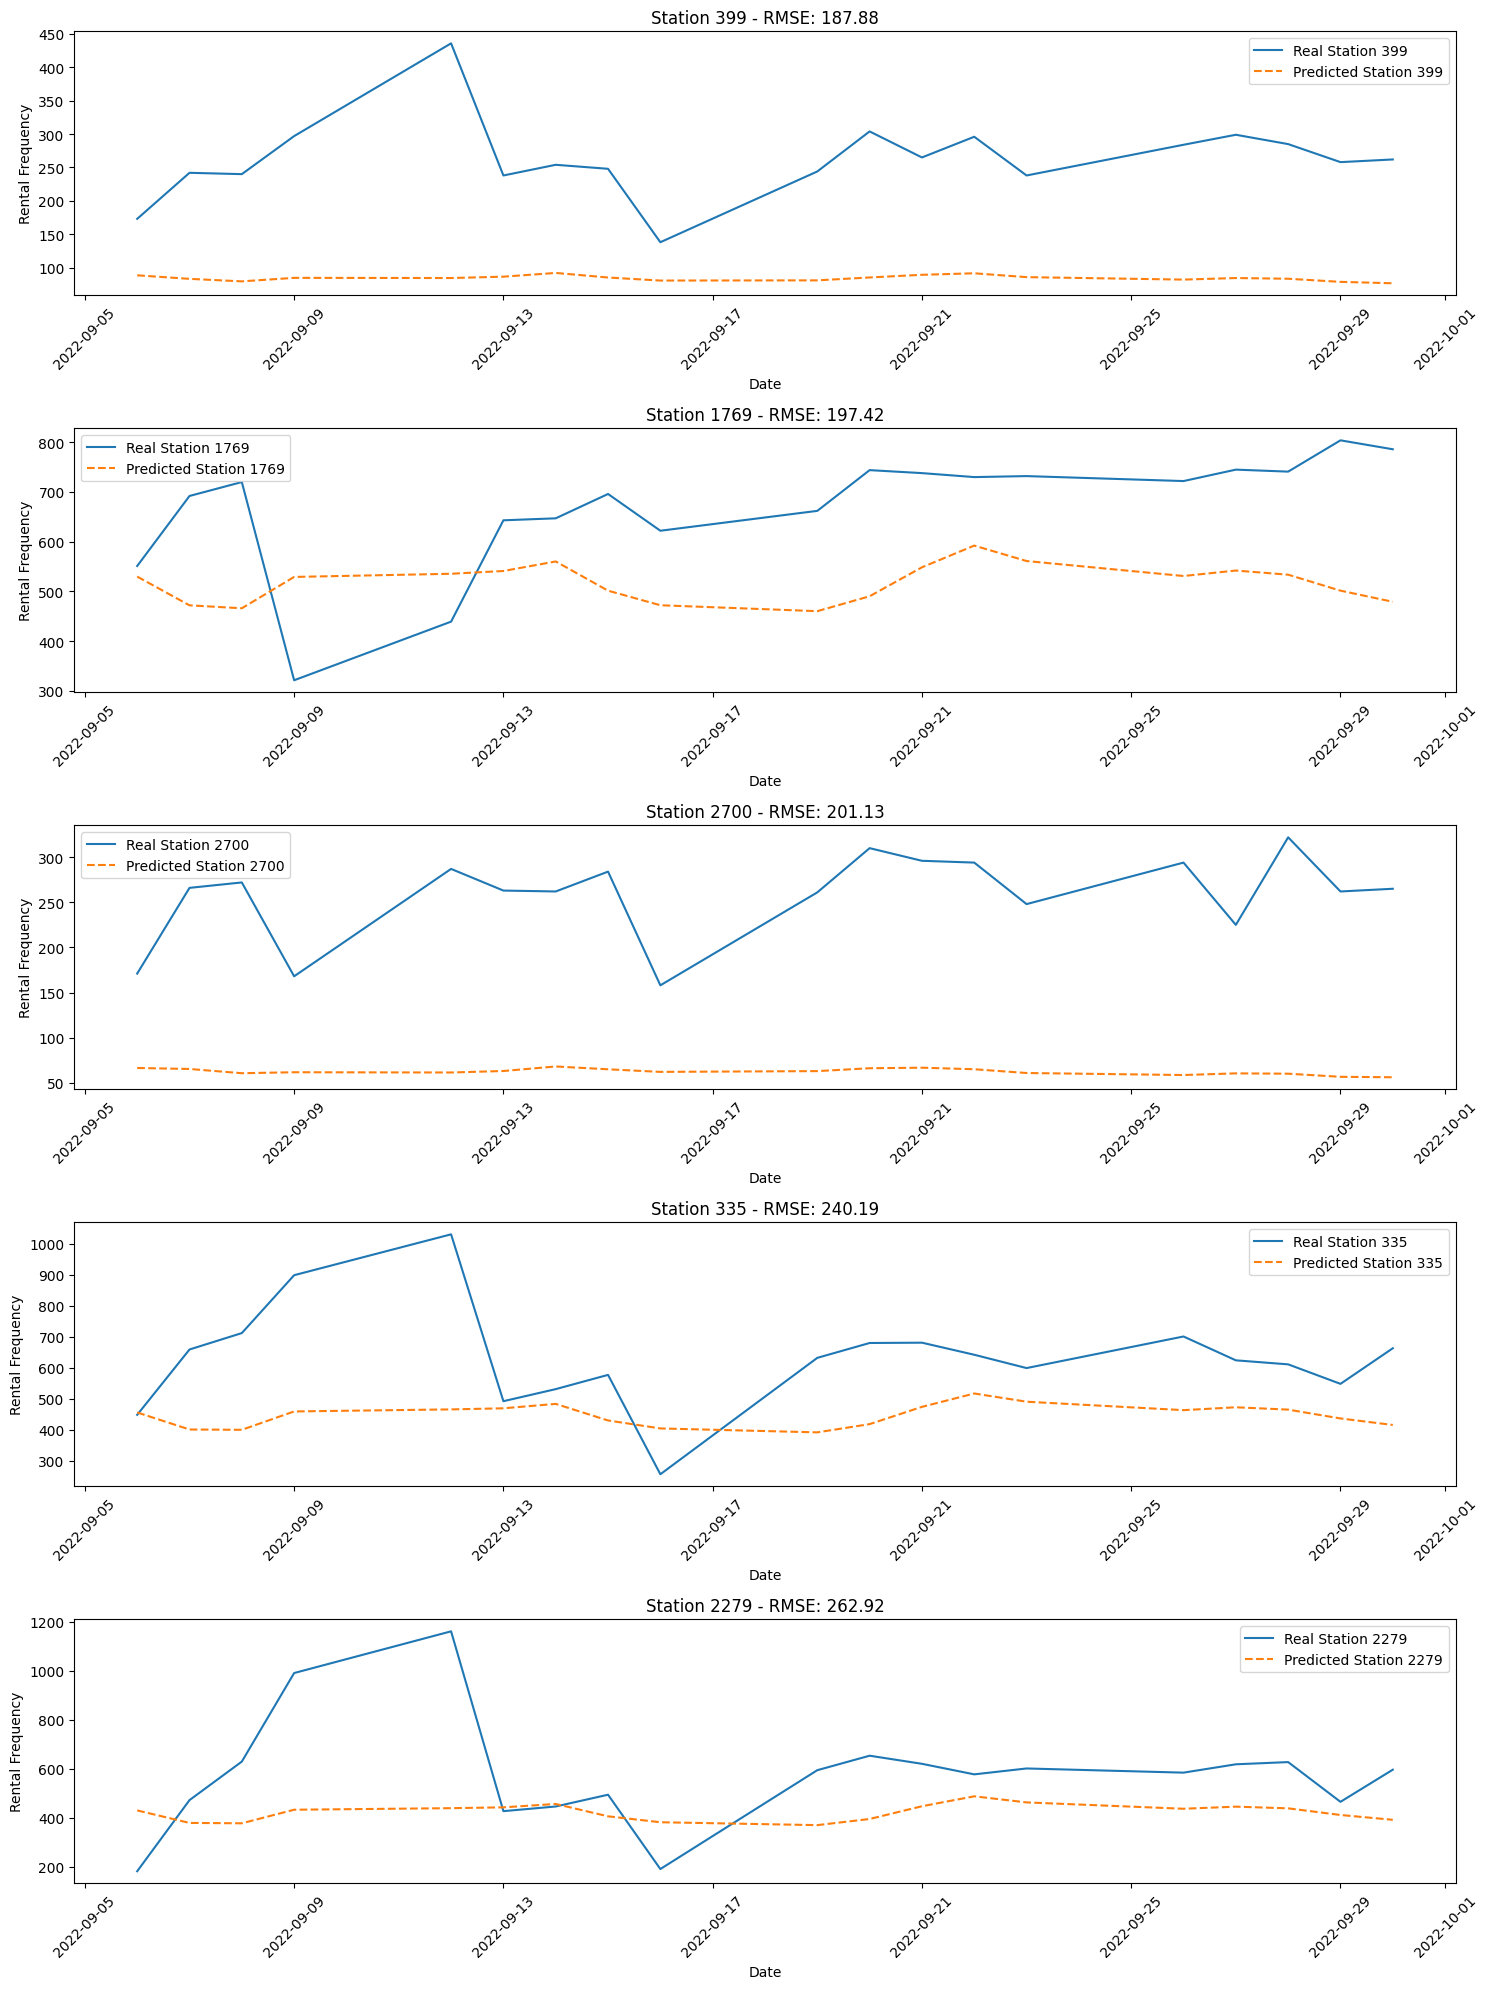

In [89]:
# 각 대여소별 RMSE 계산
rmse_per_station = np.sqrt(np.mean(np.square(y_test - y_pred), axis=0))

# RMSE가 가장 높은 상위 5개 대여소 식별
top_5_stations = np.argsort(rmse_per_station)[-5:]

# 날짜 배열 생성
dates = test_df['일시'].to_numpy()
dates = dates[3:]  # sliding window로 인해 첫날은 9/6인 4번째 날부터

# 상위 5개 대여소에 대한 예측 및 실제 값 시각화
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 20))

for idx, station in enumerate(top_5_stations):
    axes[idx].plot(dates, y_test[:, station], label=f'Real Station {station}')
    axes[idx].plot(dates, y_pred[:, station], label=f'Predicted Station {station}', linestyle='--')
    axes[idx].set_title(f'Station {station} - RMSE: {rmse_per_station[station]:.2f}')
    axes[idx].legend()
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Rental Frequency')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Mean of rental bike frequency')

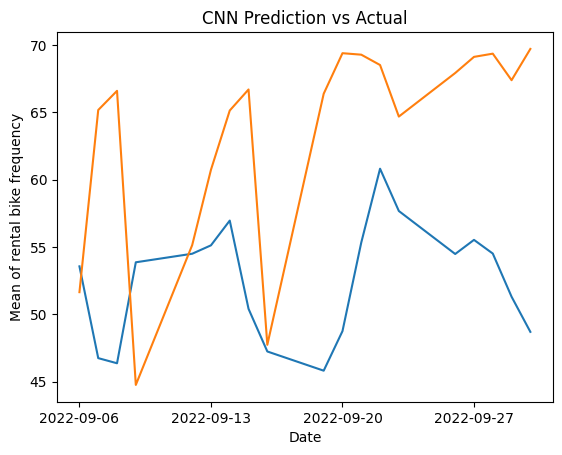

In [93]:
# 날짜 배열 생성
dates = test_df['일시'].to_numpy()
dates = dates[3:]  # sliding window로 인해 첫날은 9/6인 4번째 날부터

y_pred_mean = np.mean(y_pred, axis=1)
y_test_mean = np.mean(y_test, axis=1)

plt.plot(dates, y_pred_mean, label='Prediction Mean')
plt.plot(dates, y_test_mean, label='Actual Mean')
plt.xticks(dates[::5], rotation=0)

# y축이 0부터 시작하도록 설정
plt.ylim(bottom=0)

# 그래프 제목과 레이블 설정
plt.title('CNN Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Mean of rental bike frequency')